In [35]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Ajuste de superficies de Poincaré utilizando Series de Fourier. 

Se utiliza el método propuesto en el artículo "*Experimental and numerical study of error fields in the CNT stellarator*", DOI:10.1088/0741-3335/58/7/074002. 

En este artículo se debe realizar una parametrización de las secciones de Poincaré debido a que estas son las bases para el cálculo de errores entre la configuración experimental de las bobinas, y el modelo teórico que para el caso SCR-1 es el módulo BS-SOLCTRA.

El modelo utilizado se basa en realizar un ajuste de la superficie de Poincaré a ciertos parámetros discretizados $X$, los cuales son los coeficientes de una combinación lineal de funciones ortogonales. 

Para una superficie de flujo caracterizada por un $\rho$ arbitrario, se tiene que la expansión trignométrica que la caracteriza está dada por: 

$$R^{\rho}(\theta)=R_{0}^{\rho}+\sum_{m=1}^MR_{cm}^{\rho}\cos(m\theta)+\sum_{m=1}^MR_{sm}^{\rho}\sin(m\theta)$$

$$Z^{\rho}(\theta)=Z_0^{\rho}+\sum_{m=1}^MZ_{cm}^{\rho}\cos(m\theta)+\sum_{m=1}^MZ_{sm}^{\rho}\sin(m\theta)$$

El cálculo de estos parámetros se realiza por medio de el análisis de Fourier, con lo cual para un conjunto de datos discretos $y_i$ en un intervalo de [a,b] que en este caso se tomará por simplicidad el intervalo [0,2$\pi$], se tiene que una función que aproxima estos datos por medio de mínimos cuadrados es:

$$f(x)=\frac{1}{2}A_0+\sum_{k=1}^\infty A_n\cos(kx)+\sum_{k=1}^\infty B_n\sin(kx)$$

Donde los coeficientes $A_n, B_n$ de la serie están dados por: 

$$A_n=\frac{1}{\pi}\int_0^{2\pi}f(x)\cos(nx)dx$$
$$B_n=\frac{1}{\pi}\int_0^{2\pi}f(x)\sin(nx)dx$$
 
La implementación para la serie de datos discretizados se da a continuación:

In [62]:
def initialize_data(filename, angle_cut):

    dphi = 0.015
    phi_up = angle_cut + dphi/2
    phi_down = angle_cut - dphi/2
    R0 = 0.2477 
 
    data = np.loadtxt(filename, dtype=float, skiprows=2, delimiter='\t')

    boolarr = np.logical_and(
                    data[:,1] < phi_up,
                    data[:,1] > phi_down)
    
    pos = np.where(boolarr)[0]
    data = data[pos]
    
    rtor = data[:,0]
    thetator = data[:,2]
    phi = data[:,1]
    R = R0+np.multiply(rtor,np.cos(thetator))
    Z = np.multiply(rtor,np.sin(thetator))
    B = data[:,3]
    return np.array([R, Z, thetator, rtor, phi, B])

In [63]:
datos_fourier = initialize_data("torpath0029.txt",0)

In [64]:
rdata, zdata, theta,*_ =  datos_fourier
#plt.scatter(rdata, zdata)
def numerical_fit_data(theta, m):
        
    m_vect = np.arange(m+1)
    
    cosmat = np.cos(np.einsum('i,j', m_vect, theta))
    sinmat = np.sin(np.einsum('i,j', m_vect, theta))
    
    X = np.array([cosmat, sinmat])

    return X, m

X, m = numerical_fit_data(theta, 14)

def square_error(par, ser, data, m):
    
    param = np.array(par).reshape(2, m+1)
    dy = (1/len(data))*(data - np.einsum('ij, ijk -> k', param, ser))**2
    
    return np.sum(dy)



In [65]:
from scipy.optimize import minimize

def optim_params(data, m):
    
    rdata, zdata, theta,*_ =  data
    X, m = numerical_fit_data(theta, m)
    pa = np.random.rand(2, m+1)
    resR = minimize(square_error, pa, args = (X, rdata, m), method='BFGS', tol=1e-6)
    resZ = minimize(square_error, pa, args = (X, zdata, m), method='BFGS', tol=1e-6)
    A = resR.x.reshape(2, m+1)
    B = resZ.x.reshape(2, m+1)
    
    return A, B

In [66]:
A, B = optim_params(datos_fourier, 14)

In [67]:
R = np.einsum('ij, ijk -> k', A, X)
Z = np.einsum('ij, ijk -> k', B, X)

### Cálculo del área a partir de la función ajustada

Para el cálculo del área de las superficies se utilizó el teorema de Stokes. Con la siguiente formulación: 

$$A(r)=-\frac{1}{2}r\times B\rightarrow\nabla\times A=B$$

Suponiendo $B$ constante se tiene que, 

$$B·S=\int_{\Omega}B·dA=\oint_{\partial \Omega}A·dr$$

$$=-\frac{1}{2}\oint_{\partial \Omega}(r\times B)·dr=B·\left(\frac{1}{2}\oint_{\partial \Omega}r\times dr\right)$$

Donde $S$ es el vector de área de $\Omega$. Ahora se escoge $B=\hat{e}_i$

$$S_{\Omega}=\int_{\Omega}dA=\frac{1}{2}\oint_{\partial \Omega}r\times dr$$

Ahora bien, tratando con la siguiente imagen,  

<img src="https://drive.google.com/uc?export=view&id=1LiMBm-OUkpx2qTWkg6nSK0gL3jjo9yjP" width="500">

se toma el integrando de la siguiente manera,

$$r = R(\theta)\hat{\rho}+Z(\theta)\hat{k}$$

$$dr = R'(\theta)d\theta\hat{\rho}+Z'(\theta)d\theta\hat{k}$$

Con esto, 

$$r\times dr= \begin{vmatrix}
\hat{\rho} & \hat{\phi} & \hat{k}\\
R(\theta) & 0 & Z(\theta)\\
R'(\theta)d\theta & 0 &Z'(\theta)d\theta\\
\end{vmatrix} = -(R(\theta)Z'(\theta)d\theta-Z(\theta)R'(\theta)d\theta)\hat{\phi}$$

Entonces la integral tiene la forma, 

$$S=\frac{1}{2}\int_0^{2\pi}-(R(\theta)Z'(\theta)d\theta-Z(\theta)R'(\theta)d\theta)\hat{\phi}$$

Como solo se ocupa la magnitud se toma, 

$$S=\frac{1}{2}\int_0^{2\pi}(R(\theta)Z'(\theta)-Z(\theta)R'(\theta))d\theta$$




In [68]:
def vects(m, N):
    t = np.linspace(0, 2*np.pi, num=200)
    mvect = np.arange(m+1)
    cosvect = np.cos(np.einsum('i,k', mvect, t))
    sinvect = np.sin(np.einsum('i,k', mvect, t))
    X = np.array([cosvect, sinvect])
    dX = np.array([sinvect, cosvect])
    return X, dX


X, dX = vects(m, 200)


def derivatives(A, B, m, X, dX):
    one = np.ones(m+1)
    R = np.einsum('ij, ijk->k', A, X)
    Z = np.einsum('ij, ijk->k', B, X)
    mvect = np.arange(m+1)
    dRdTcoefs = np.zeros((2, m+1))
    dZdTcoefs = np.zeros((2, m+1))
    
    for j in range(m+1): 

        dRdTcoefs[:,j] = -A[:,j]*j
        dZdTcoefs[:,j] = B[:,j]*j
    
    dRdT = np.einsum('ij,ijk->k', dRdTcoefs, dX)
    dZdT = np.einsum('ij,ijk->k', dZdTcoefs, dX)
    
    return R, Z, dRdT, dZdT

R, Z, dRdT, dZdT = derivatives(A, B, m, X, dX)

In [69]:
#Celda de prueba para el caso específico de un solo archivo. 

def area_calculation(R, dRdT, Z, dZdT, t):
    """
    Se define el cálculo del área integrando la función propuesta anteriormente.

    :param integrand: función, integrando del cálculo propuesto. 
    """
    
    integrand = R*dZdT-Z*dRdT
    
    area = np.trapz(integrand, t)
    
    return area

area = 0.5*area_calculation(R, dRdT, Z, dZdT, t)
print("Area transversal: {:.6f}".format(area))

Area transversal: 0.004536


In [70]:
os.chdir('../Johan/SCR_1/Infraestructura')

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../Johan/SCR_1/Infraestructura'

In [71]:
import time
def extractdirectorydata(dir_path, angle): 
    """
    Extrae los datos de todos las trayectorias competentes y realiza los ajustes con ellos de forma iterativa. 

    :param dir_path: path al directorio donde se encuentran los archivos de las trayectorias. 
    :param angle: ángulo en el cuál realizar el ajuste de la superficie de Poincaré.  

    """
    main_dir = os.getcwd()
    list_archiv = os.listdir(dir_path)
    list_archiv.sort()
    poincare_coords = []
    os.chdir(dir_path)

    for iArch in list_archiv:
        poincare_coords.append(initialize_data(iArch, angle))
        print("Feedback: "+str(iArch))
    
    iRange = len(poincare_coords)
    fourier_series_params = []

    for i in range(iRange):
        if len(poincare_coords[i]) != 0: 
            fourier_series_params.append(optim_params(poincare_coords[i], 16))
        else: 
            continue
    
    os.chdir(main_dir)
    return fourier_series_params
    
a = time.time()
data = extractdirectorydata("../../../results_toroidal_cartesian", 0)
b = time.time()
print(b-a)


Feedback: torpath0029.txt
Feedback: torpath0030.txt
Feedback: torpath0033.txt
Feedback: torpath0035.txt
Feedback: torpath0036.txt
Feedback: torpath0037.txt
Feedback: torpath0044.txt
Feedback: torpath0045.txt
Feedback: torpath0047.txt
Feedback: torpath0048.txt
Feedback: torpath0049.txt
Feedback: torpath0051.txt
Feedback: torpath0064.txt
Feedback: torpath0068.txt
Feedback: torpath0070.txt
Feedback: torpath0072.txt
Feedback: torpath0073.txt
Feedback: torpath0074.txt
171.21709823608398


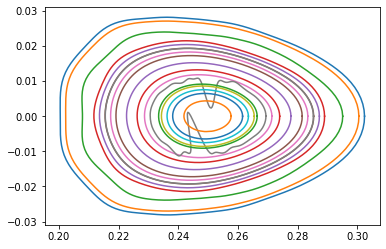

In [77]:
def calculations(fourier_series_params, m):
    """
    Realiza los cálculos de áreas y devuelve los coeficientes calculados para todos los archivos.

    :param fourier_series_params: contiene las estructuras de resultados para cada fit. 
    :params R_c, R_s: parámetros definidos para el modelo.
    """
    iRange = len(fourier_series_params)
    areas, RcoefsC, RcoefsS, ZcoefsC, ZcoefsS = [], [], [], [], []

    for i in range(iRange):

        A, B = fourier_series_params[i]
        

        #cálculo análitico de las áreas
        X, dX = vects(m, 200)
        R, Z, dRdT, dZdT = derivatives(A, B, m, X, dX)
        plt.plot(R,Z)
        
        area = 0.5*area_calculation(R, dRdT, Z, dZdT, t)

        areas.append(area)
        RcoefsC.append(A[0])
        RcoefsS.append(A[1])
        ZcoefsC.append(B[0])
        ZcoefsS.append(B[1])

    return areas, RcoefsC, RcoefsS, ZcoefsC, ZcoefsS

A, RcC, RcS, ZcC, ZcS = calculations(data, 16)

In [78]:
def matrix_sorting(A, RcC, RcS, ZcC, ZcS):
    
    """
    Ordena los coeficientes por tamaño de área, de menor a mayor. 

    :param A: vector de áreas calculado para cada superficie en el diagrama de Poincaré.
    :params RcC|S, ZcC|S: vectores de coeficientes para las series de Fourier.
    """

    RC = RcC
    RS = RcS
    ZC = ZcC
    ZS = ZcS
    
    a = np.array(area)
    rhos = np.sqrt(a/max(a))

    for i in range(len(rhos)): 
        RS[i].insert(0,rhos[i])
        RC[i].insert(0,rhos[i])
        ZS[i].insert(0,rhos[i])
        ZC[i].insert(0,rhos[i])

    RS = sorted(RS,key=lambda x: x[0])
    RC = sorted(RC,key=lambda x: x[0])
    ZS = sorted(ZS,key=lambda x: x[0])
    ZC = sorted(ZC,key=lambda x: x[0])

    return np.array(rhos), np.array(RS), np.array(RC), np.array(ZS), np.array(ZC)

Rho, rs, rc, zs, zc = matrix_sorting(A, RcC, RcS, ZcC, ZcS)
Rho.sort(axis=0)

AttributeError: 'numpy.ndarray' object has no attribute 'insert'

#### Base vectorial de $R(\rho)$

Se tiene que la base polinomial en la que cada $R_c(\rho)$ puede ser expandido está dada por los polinomios $P_s(\rho)$ que cumplen con el siguiente producto interno,

$$\int_0^1 P_i(\rho)P_j(\rho)d\rho = \delta_{ij}$$

Donde $\delta_{ij}$ es el delta de Kronecker. 

Para poder obtener la expansión, 

$$R_{c1}(\rho)=R_{c10}P_0(\rho)+R_{c11}P_1(\rho)+···+R_{c1S}P_S(\rho)$$

Primero se necesita calcular los polinomios que forman esta base a partir de la base $\varphi :\left[1,\rho, \rho^2,...,\rho^S\right]$ por medio del proceso de ortonormalización de Gram-Schmidt. 

Para esto se tiene que,

$$P_0(\rho) = 1$$

$$P_1(\rho) = x - \left<x|P_0\right>P_0(\rho),$$

$$P_2(\rho) = x^2 - \left<x^2|P_0\right>P_0(\rho)-\left<x^2|P_1\right>P_1(\rho),$$

$$·$$
$$·$$
$$·$$

$$P_S(\rho) = x^S - \left<x^S|P_0\right>P_0(\rho)-···-\left<x^S|P_{s-1}\right>P_{s-1}(\rho),$$


In [ ]:
#from math import isclose
 
def inner_product(f, g):
    """
    Definición del producto interno del espacio vectorial formado por la base de polinomios propuesta 
    artículo mencionado. 

    :param f, g: funciones a evaluar. 
    """
    integrand = sympy.lambdify(x,f*g)
    value, err = scipy.integrate.quad(integrand,0,1)
    return [err, value]

In [ ]:
#Definición del set de funciones para el proceso de gram schmidt, en este caso son polinomios 
#de la forma x^n 
 
def gen_funcs(n):
    """
    Genera la base polinomial x^n

    :param n: último grado de la base polinomial.
    """
    x = sympy.symbols('x')
 
    functions = list()
    for i in range(n):
        functions.append(x**i)
    
    functions = np.array(functions)
 
    return functions
 
def GM_ortho(funcs):
    """
    Define el proceso de Gram-Schmidt para transformar de una base V, a
    una base ortonormal. 

    :param funcs: funciones base
    """
    shp = len(funcs)
    ortho_funcs = list()
    phi = funcs[0]
    ortho_funcs.append(phi)
 
    for i in range(1,shp):
        psi = funcs[i]
        for j in ortho_funcs: 
            psi = psi - (inner_product(j,funcs[i])[1])*j
 
            phi = psi/(inner_product(psi,psi)[1]**0.5)
        ortho_funcs.append(phi)
 
    return ortho_funcs

funcsis = gen_funcs(8)
orthofuncs = GM_ortho(funcsis)
 
GM_ortho(funcsis)

In [ ]:
#ajuste de los coeficientes R y Z

def mod_esp_poli(x,funcs):
    """
    Se propone el modelo de combinación lineal para expresar una función f(x)
    en términos de una rbase ortonormal. 
    :param x: variable symfit
    :param funcs: funciones ortonormales 
    """
    n = len(funcs)
    params = parameters(','.join(['O_{}'.format(i) for i in range(0, n+1)]))
    model = sum(O_i * funcs_i for O_i, funcs_i in zip(params, funcs))

    return model, params

modelo, params = mod_esp_poli(x,orthofuncs)

model_dict_2 = {y: modelo}

print(model_dict_2)


In [ ]:
#Se realiza el mismo procedimiento de ajuste de datos que se realizó
#anteriormente. 
crc = rc.T
crs = rs.T
czc = zc.T
czs = zs.T

def fit_coefs(cor,model): 
    """
    Ajuste de los datos de coeficientes con áreas
    
    """
    fits = list()
    iRange = len(cor)
    for i in range(1,iRange): 
        fit = Fit(model, x=cor[0],y=cor[i])
        fit_result = fit.execute()
        fits.append(fit_result)
        #print(i)
    return fits

crcfits = fit_coefs(crc, model_dict_2)
crsfits = fit_coefs(crs, model_dict_2)
czcfits = fit_coefs(czc, model_dict_2)
czsfits = fit_coefs(czs, model_dict_2)


In [ ]:
def retcoef_2(i,xfit, R_c): 
    """

    """
    newRcoef = list()
    for r in range(len(R_c)):
        for param in xfit[i].params.items():
            if param[0] == str(R_c[r]):
                newRcoef.append([str(R_c[r])+str(i),param[1]])
            else:
                continue

    return newRcoef



In [ ]:
#Se propone el vector X que se utilizará después para el algoritmo de optimización

def return_poly_coefs(rc,rs,zc,zs): 
    crc = rc.T
    crs = rs.T
    czc = zc.T
    czs = zs.T
    
    x = sympy.symbols('x')
    funcs = gen_funcs(8)
    model, params = mod_esp_poli(x,funcs)
    model_dict = {y: model}
    crcfits = fit_coefs(crc, model_dict)
    crsfits = fit_coefs(crs, model_dict)
    czcfits = fit_coefs(czc, model_dict)
    czsfits = fit_coefs(czs, model_dict)
    iRange1 = len(crcfits)
    iRange2 = len(crsfits)
    rcr = list()
    rsr = list()
    zcr = list()
    zsr = list()

    for i in range(iRange1): 
        coefrc = retcoef_2(i,crcfits, params)
        coefzc = retcoef_2(i,czcfits, params)
        rcr.append(coefrc)
        zcr.append(coefzc)
    
    for i in range(iRange2):
        coefrs = retcoef_2(i,crsfits, params)
        coefzs = retcoef_2(i,czsfits, params)
        rsr.append(coefrs)
        zsr.append(coefzs)

    rcr = np.array(rcr)
    rsr = np.array(rsr)
    zcr = np.array(zcr)
    zsr = np.array(zsr)
            
    X = rcr.T[1].astype(float)
    X = np.append(X,rsr.T[1].astype(float))
    X = np.append(X,zcr.T[1].astype(float))
    X = np.append(X,zsr.T[1].astype(float))

    return X

X = return_poly_coefs(rc,rs,zc,zs)

    

Ahora se propondrá el siguiente método para la optimización de estos parámetros. 



In [ ]:
print(X)